### Attribution

Many parts of this notebook are taken or adapted from a version of the benchmark [blog post](https://www.drivendata.co/blog/cloud-cover-benchmark/) posted on the [On Cloud N](https://www.drivendata.org/competitions/83/cloud-cover/page/396/) competition website. Tweaks have been made to run directly in the planetary computer hub. 

# Imports

In [1]:
%%capture
!pip install pandas_path pytorch_lightning cloudpathlib loguru typer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import pyproj
import shutil
import rasterio
import rioxarray

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import xrspatial.multispectral as ms

from pandas_path import path  # noqa
from pathlib import Path
from sklearn.utils import shuffle
from PIL import Image
from my_preprocessing import train_dev_test_split

## Global Variables

In [4]:
SEED = 42
BANDS = ["B02", "B03", "B04", "B08"]
PERCENT_TRAIN = 0.6
PERCENT_DEV = 0.2
PERCENT_TEST = 0.2

In [5]:
DATA_DIR = Path("/driven-data/cloud-cover")
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

# EDA

#### Metadata

Let's start by looking at the metadata for the train and test sets, to understand what the images in this competition capture.

In [6]:
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


#### Images

Next, let's explore the actual satellite images - the star of the show for this challenge!

For convenience, let's first add the paths to all of the feature images per chip. Remember, the folder for each chip has four images, each of which corresponds to a different band of light wavelengths.

In [7]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)["label_path"].path.exists().all()

    return df

train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_labels/adwp.tif
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_labels/adwu.tif
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_labels/adwz.tif
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,/driven-data/cloud-cover/train_features/adxp/B...,/driven-data/cloud-cover/train_features/adxp/B...,/driven-data/cloud-cover/train_features/adxp/B...,/driven-data/cloud-cover/train_features/adxp/B...,/driven-data/cloud-cover/train_labels/adxp.tif
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,/driven-data/cloud-cover/train_features/aeaj/B...,/driven-data/cloud-cover/train_features/aeaj/B...,/driven-data/cloud-cover/train_features/aeaj/B...,/driven-data/cloud-cover/train_features/aeaj/B...,/driven-data/cloud-cover/train_labels/aeaj.tif


Each image is a *GeoTIFF*, a raster image file that contains geographic metadata. This metadata can include coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package [rasterio](https://rasterio.readthedocs.io/en/latest/) makes it easy to interact with our geospatial raster data.

Lets look at the red visible band (B04) image for a random chip.

In [8]:
example_chip = train_meta[train_meta["chip_id"] == "pbyl"].iloc[0]

example_chip

chip_id                                                    pbyl
location                                                 Lodwar
datetime                                   2020-09-08T08:09:15Z
cloudpath                            az://./train_features/pbyl
B02_path      /driven-data/cloud-cover/train_features/pbyl/B...
B03_path      /driven-data/cloud-cover/train_features/pbyl/B...
B04_path      /driven-data/cloud-cover/train_features/pbyl/B...
B08_path      /driven-data/cloud-cover/train_features/pbyl/B...
label_path       /driven-data/cloud-cover/train_labels/pbyl.tif
Name: 6571, dtype: object

The example chip is an image taken from Lodwar, a northwestern town in Kenya.

In [9]:
with rasterio.open(example_chip["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 771935.0,
        0.0, -10.0, 331300.0)}

We can see that the features are single-band images, with a shape of 512 x 512. The pixel values for each image measure the strength of light reflected back to the satellite for the specific set of wavelengths in that band. The array below shows the strength of red visible light, with wavelengts around 665 nm.

We can also see that there are no missing values in the image. This should be the case for all of the provided competition feature data.

In [10]:
# what does the image array look like?
print("Image array shape:", img_array.shape)
img_array

Image array shape: (512, 512)


array([[ 519,  532,  556, ..., 3662, 3564, 3544],
       [ 549,  539,  562, ..., 3604, 3520, 3518],
       [ 572,  524,  506, ..., 3514, 3488, 3518],
       ...,
       [1216, 2062, 2898, ..., 4050, 3610, 3328],
       [1632, 1932, 2588, ..., 4108, 3918, 3736],
       [1766, 2040, 2272, ..., 4152, 4028, 3824]], dtype=uint16)

In [11]:
np.isnan(img_array).sum()

0

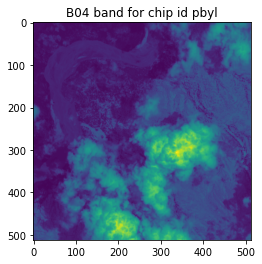

In [12]:
plt.imshow(img_array)
plt.title(f"B04 band for chip id {example_chip.chip_id}")
plt.show()

#### Coordinates

Using the metadata returned by `rasterio`, we can also get longitude and latitude coordinates.

In [13]:
# longitude/latitude of image's center
with rasterio.open(example_chip["B04_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

Longitude: 35.46935026347422, latitude: 2.9714117132510944


In [14]:
bounds

BoundingBox(left=771935.0, bottom=326180.0, right=777055.0, top=331300.0)

We have the longitude and latitude of the center of the image, but the bounding box values look very different. That's because the bounding box is given in whatever coordinate reference system the image is projected in, rather than traditional longitude and latiude. We can see which system with the `crs` value from the metadata.

We can convert the bounding box to longitude and latitude using `pyproj`.

In [15]:
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)

In [16]:
left, bottom, right, top = lat_long_bounds(example_chip["B04_path"])
print(
    f"Image coordinates (lat, long):\nStart: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long):
Start: (2.948221298028172, 35.44628398518643)
End: (2.9946024439490517, 35.492417498478574)


#### True color image

We can make a composite image from the three visible bands (blue, green, and red) to visualize a high-quality, true color image. To show the true color image, we'll use the `rioxarray` and `xrspatial` packages designed for Sentinel-2 satellite data.

In [17]:
def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = data_dir / chip_id
    red = rioxarray.open_rasterio(chip_dir / "B04.tif").squeeze()
    green = rioxarray.open_rasterio(chip_dir / "B03.tif").squeeze()
    blue = rioxarray.open_rasterio(chip_dir / "B02.tif").squeeze()

    return ms.true_color(r=red, g=green, b=blue)

Text(0.5, 1.0, 'True color image for chip id pbyl')

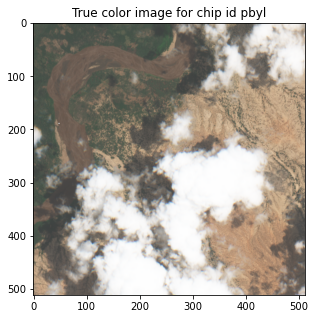

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {example_chip.chip_id}")

That's a pretty high quality image!

Let's look at a few random training chips and their cloud labels.

In [19]:
def display_random_chip(random_state):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]

    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = Image.open(random_chip.label_path)
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {random_chip.chip_id} label")

    plt.tight_layout()
    plt.show()

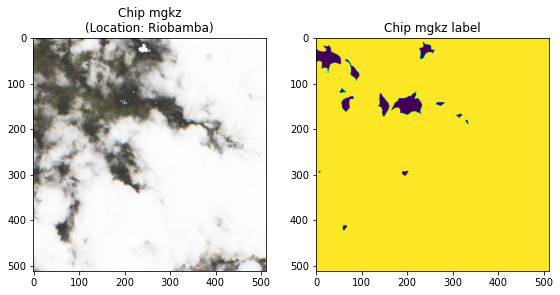

In [20]:
display_random_chip(1)

From the example chips, we can see that there is a very big variation in the amount of cloud cover per chip. The chip from Riobamba, Ecuador is almost completely obscured by clouds, while the chip from Macapá, Brazil has almost none.

<a id='split-data'></a>

# Split the data

Before we startin training, we'll split our dataset into three parts: training, development, and test. Then we'll separate the features from the lables to end up with 6 datasets in total. 

In [25]:
# Split data using stratified random sample such that each dataset has proportional amount of 
# chips from each location
train_data, dev_data, test_data = train_dev_test_split(train_meta, 
                                                       column='location', 
                                                       pct_train=PERCENT_TRAIN, 
                                                       pct_dev=PERCENT_DEV, 
                                                       pct_test=PERCENT_TEST)

In [26]:
# separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

X_train = train_data[feature_cols].copy()
y_train = train_data[["chip_id", "label_path"]].copy()

X_dev = dev_data[feature_cols].copy()
y_dev = dev_data[["chip_id", "label_path"]].copy()

X_test = test_data[feature_cols].copy()
y_test = test_data[["chip_id", "label_path"]].copy()

<a id='code-exec'></a>

### Code Execution Format


<div class="alert alert-info">
<strong>This is a code submission challenge! Rather than submitting your predicted labels, you'll package everything needed to do inference and submit that for containerized execution.</strong> The <a href="https://github.com/drivendataorg/cloud-cover-runtime">runtime repository</a> contains the complete specification for the runtime. See the Code Submission Format <a href="https://www.drivendata.org/competitions/83/cloud-cover/page/412/">page</a> for full details. You can learn more about how our code execution competitions work <a href="https://www.drivendata.co/blog/code-execution-competitions/">here</a>.
</div>

Rather than just generating predictions, this benchmark will show you how to create a correct submission for code execution. Your final submission will be a zipped archive called `submission.zip`. We'll create a folder called `benchmark_src`, and develop a complete code execution submission in that folder. `benchmark_src` will ultimately include:

1. The weights for our trained model

2. A `main.py` script that loads the model, performs inference on images stored in `data/test_features`, generates chip-level predictions, and saves them out to `predictions/`. File names should match the chip IDs from the test dataset. For example, if the test set includes a chip with ID `abcd`, running `main.py` must write out a predicted cloud cover TIF mask to `predictions/abcd.tif`. The predictions should be .tifs with values of `1` and `0` indicating cloud or no cloud.

3. Any additional scripts that `main.py` needs in order to run

`main.py` must be able to run without getting any input arguments, so make sure you set all your defaults so that calling `python main.py` alone runs the full process. **Your final submission should *not* include prediction files.**

All of the key code for inference is written out to scripts in `benchmark_src` using the line magic `%%file` instead of being run directly in this notebook. The final scripts that are written out by this notebook are also saved in a folder of the [runtime repo](https://github.com/drivendataorg/cloud-cover-runtime/tree/main/benchmark_src).

In [28]:
# create benchmark_src folder
submission_dir = Path("benchmark_src")
if submission_dir.exists():
    shutil.rmtree(submission_dir)

submission_dir.mkdir(parents=True)

We'll run inference in this notebook by importing classes and functions from the scripts in `benchmark_src`.

<a id="build-model"></a>

# Build the model

As a starting point, we'll build a basic neural network model using some of the standard libraries. That way there's lots of room for you to make improvements!

We'll use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/), a package that introduces useful conventions for training deep learning models on top of PyTorch. Our model will start with a publicly available [convolutional neural network](https://www.youtube.com/watch?v=aircAruvnKk&t=995s) called [U-Net](https://arxiv.org/abs/1505.04597) that is pretrained for [semantic segmentation](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47).

**U-Net** was first designed to help process biomedical imaging and identify things like signs of disease. The basic structure is an encoder network followed by a decoder network. We'll use a pretrained backbone called [ResNet34](https://arxiv.org/abs/1512.03385) as our encoder.

#### `CloudDataset`

The first step of building the model is actually writing a class that will tell the model how to handle our feature data. Thankfully, the PyTorch `Dataset` and `DataLoader` classes take care of most of this for us! A `Dataset` object allows us to define custom methods for working with the data, and a `DataLoader` object parallelizes data loading. If you haven't worked with these classes before, we highly recommend this short [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

We'll write a custom dataset called `CloudDataset` that reads our satellite image training data into memory, converts the data to PyTorch tensors, and serves the data to our model in batches. Our class will inherit from `torch.utils.data.Dataset`, and [override](https://www.tutorialspoint.com/overriding-methods-in-python) a few key methods:

`__len__()`: return the number of chips in the dataset

`__getitem__()`: return a sample from the dataset as a dictionary, with keys for:
- `chip_id`: unique identifiers for each chip

- `chip`: the image array of the chip, with all four provided bands combined. The shape of each image array will be (4, 512, 512). 

- `label`: the label tif mask, if it exists

In [29]:
%%file {submission_dir}/cloud_dataset.py
import numpy as np
import pandas as pd
import rasterio
import torch
from typing import Optional, List


class CloudDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(
        self,
        x_paths: pd.DataFrame, # : syntax specifies datatype for each parameter for CloudDataset objects
        bands: List[str],
        y_paths: Optional[pd.DataFrame] = None,
        transforms: Optional[list] = None,
    ):
        """
        Instantiate the CloudDataset class.

        Args:
            x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands
            bands (list[str]): list of the bands included in the data
            y_paths (pd.DataFrame, optional): a dataframe with a for each chip and columns for chip_id
                and the path to the label TIF with ground truth cloud cover
            transforms (list, optional): list of transforms to apply to the feature data (eg augmentations)
        """
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms
        self.bands = bands

    def __len__(self):
        return len(self.data)
    
    # Similar to pop, helps iterate through dataset
    def __getitem__(self, idx: int):
        # Loads an n-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        band_arrs = []
        for band in self.bands:
            with rasterio.open(img[f"{band}_path"]) as b:
                band_arr = b.read(1).astype("float32")
            band_arrs.append(band_arr)
        x_arr = np.stack(band_arrs, axis=-1) # 3-dimensional array

        # Apply data augmentations, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1]) # re-orders array to match expected format needed for model

        # Prepare dictionary for item
        item = {"chip_id": img.chip_id, "chip": x_arr}

        # Load label if available
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1).astype("float32")
            # Apply same data augmentations to the label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            item["label"] = y_arr

        return item

Writing benchmark_src/cloud_dataset.py


Our custom dataset does not implement any transformations or feature engineering. Applying data augmentations and transformations is a good way to train your model on a wider variety of scenarios without needing more data. The [albumentations](https://albumentations.ai/) library is a good place to start if you want to implement some of these!

#### Loss class

Next we'll set up a custom loss class for calculating intersection over union (IOU), the competition [performance metric](https://www.drivendata.org/competitions/83/cloud-cover/page/398/#performance-metric). During training, we'll define the best model as the one that gets the highest IOU on the validation set.

For our training steps, we'll minimize [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression). Cross-entropy loss broadly evaluates the differences between predicted and ground truth pixels and averages over all pixels. For this, we can use the built-in `torch.nn.CrossEntropyLoss()`.

In [30]:
%%file {submission_dir}/losses.py
import numpy as np


def intersection_over_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum() / union.sum()

Writing benchmark_src/losses.py


#### `CloudModel`

Now is the moment we've all been waiting for - coding our actual model! 

Again, we'll make our lives simpler by starting with the [`pl.LightningModule`](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html) class from Pytorch Lightning. This comes with most of the logic we need, so we only have to specify components that are specific to our modeling setup. Our custom `CloudModel` class will define:

- `__init__`: how to instantiate a `CloudModel` class

- `forward`: forward pass for an image in the neural network propogation

- `training_step`: switch the model to train mode, implement the forward pass, and calculate training loss (cross-entropy) for a batch

- `validation_step`: switch the model to eval mode and calculate validation loss (IOU) for the batch

- `train_dataloader`: call an iterable over the training dataset for automatic batching

- `val_dataloader`: call an iterable over the validation dataset for automatic batching

- `configure_optimizers`: configure an [optimizer](https://pytorch.org/docs/stable/optim.html) and a [scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html) to dynamically adjust the learning rate based on the number of epochs

- `_prepare_model`: load the U-Net model with a ResNet34 backbone from the `segmentation_models_pytorch` package

In [31]:
%%file {submission_dir}/cloud_model.py
from typing import Optional, List

import pandas as pd
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch

try:
    from cloud_dataset import CloudDataset
    from losses import intersection_over_union
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.losses import intersection_over_union


class CloudModel(pl.LightningModule):
    def __init__(
        self,
        bands: List[str],
        x_train: Optional[pd.DataFrame] = None,
        y_train: Optional[pd.DataFrame] = None,
        x_val: Optional[pd.DataFrame] = None,
        y_val: Optional[pd.DataFrame] = None,
        hparams: dict = {},
    ):
        """
        Instantiate the CloudModel class based on the pl.LightningModule
        (https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

        Args:
            bands (list[str]): Names of the bands provided for each chip
            x_train (pd.DataFrame, optional): a dataframe of the training features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_train (pd.DataFrame, optional): a dataframe of the training labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            x_val (pd.DataFrame, optional): a dataframe of the validation features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_val (pd.DataFrame, optional): a dataframe of the validation labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            hparams (dict, optional): Dictionary of additional modeling parameters.
        """
        super().__init__() # inherits from super class
        self.hparams.update(hparams)
        self.save_hyperparameters()

        # required
        self.bands = bands

        # optional modeling params
        self.backbone = self.hparams.get("backbone", "resnet34") # Steve used MobileNetV2 (which uses imagenet weights), can try timm
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.patience = self.hparams.get("patience", 4) # sets threshold for training to stop because loss function hasn't decreased for x many times in a row
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.gpu = self.hparams.get("gpu", False)
        self.transform = None

        # Instantiate datasets, model, and trainer params if provided
        self.train_dataset = CloudDataset(
            x_paths=x_train,
            bands=self.bands,
            y_paths=y_train,
            transforms=self.transform,
        )
        self.val_dataset = CloudDataset(
            x_paths=x_val,
            bands=self.bands,
            y_paths=y_val,
            transforms=None,
        )
        self.model = self._prepare_model()

    ## Required LightningModule methods ##

    def forward(self, image: torch.Tensor):
        # Forward pass
        return self.model(image)

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.train_dataset.data is None:
            raise ValueError(
                "x_train and y_train must be specified when CloudModel is instantiated to run training"
            )

        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True) # takes data to GPU

        # Forward pass
        preds = self.forward(x) # Propogates input data through network

        # Log batch loss
        loss = torch.nn.CrossEntropyLoss(reduction="none")(preds, y).mean() # Measures how well model predicted on last forward propogation
        self.log(
            "loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.val_dataset.data is None:
            raise ValueError(
                "x_val and y_val must be specified when CloudModel is instantiated to run validation"
            )

        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False) # Prevents network for adjusting weights (through gradient descent) while doing validation

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1  # convert to int

        # Log batch IOU
        batch_iou = intersection_over_union(preds, y)
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

    ## Convenience Methods ##

    def _prepare_model(self):
        # Instantiate U-Net model
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=4,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()

        return unet_model

Writing benchmark_src/cloud_model.py


In [32]:
from benchmark_src.cloud_model import CloudModel

/srv/conda/envs/notebook/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/srv/conda/envs/notebook/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/srv/conda/envs/notebook/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


<a id='fit-model'></a>

# Fit the model

It's go time! The only required arguments to fit the model are the train features, the train labels, the validation features, and the validation labels. 

We've opted to train with all of the defaults hyperparameters defined in `__init__` for simplicity, so there is a lot of room for tweaks and improvements! You can experiment with things like learning rate, patience, batch size, and much much more.

In [33]:
import warnings

warnings.filterwarnings("ignore")

In [34]:
# Set up pytorch_lightning.Trainer object
cloud_model = CloudModel(
    bands=BANDS,
    x_train=X_train,
    y_train=y_train,
    x_val=X_dev,
    y_val=y_dev,
    hparams={"num_workers": 7, "batch_size": 8},
)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="iou_epoch", mode="max", verbose=True
)
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(cloud_model.patience * 3),
    mode="max",
    verbose=True,
)

trainer = pl.Trainer(
    gpus=1,
    fast_dev_run=False,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [35]:
# Fit the model
trainer.fit(model=cloud_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.759    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

KeyError: 1

Our best IOU on the validation split is 0.887.

If you'd like to track changes in performance more closely, you could log information about metrics across batches, epochs, and models through the [TensorBoard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) UI.

<a id='generate-submission'></a>

### Generate a submission

Now that we have our trained model, we can generate a full submission. **Remember that this is a [code execution](https://www.drivendata.org/competitions/83/cloud-cover/page/412/) competition,** so you will be submitting our inference code rather than our predictions. We've already written out our key class definition to scripts in the folder `benchmark_src`, which now contains:

```
benchmark_src
├── cloud_dataset.py
├── cloud_model.py
└── losses.py
```

To submit to the competition, we still need to:

1. Store our trained model weights in `benchmark_src` so that they can be loaded during inference

2. Write a `main.py` file that loads our model weights, generates predictions for each chip, and saves the predictions to a folder called `predictions` in the same directory as itself

3. Zip the contents of `benchmark_src/` - not the directory itself - into a file called `submission.zip`. 

4. Upload `submission.zip` to the competition submissions page. The file will be unzipped and `main.py` will be run in a [containerized execution environment](https://github.com/drivendataorg/cloud-cover-runtime) to calculate our model's IOU.

#### 1. Save our model

First, let's make a folder for our model assets, and save the weights for our trained model using PyTorch's handy `model.save()` method. The below saves the weights to `benchmark_src/assets/cloud_model.pt`.

In [ ]:
# save the model
submission_assets_dir = submission_dir / "assets"
submission_assets_dir.mkdir(parents=True, exist_ok=True)

model_weight_path = submission_assets_dir / "cloud_model.pt"
torch.save(cloud_model.state_dict(), model_weight_path)

#### 2. Write `main.py`

Now we'll write out a script called `main.py` to `benchmark_src`, which runs the whole inference process using the saved model weights.

In [ ]:
%%file benchmark_src/main.py
import os
from pathlib import Path
from typing import List

from loguru import logger
import pandas as pd
from PIL import Image
import torch
import typer

try:
    from cloud_dataset import CloudDataset
    from cloud_model import CloudModel
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.cloud_model import CloudModel


ROOT_DIRECTORY = Path("/codeexecution")
PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / "predictions"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Set the pytorch cache directory and include cached models in your submission.zip
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "assets/torch")


def get_metadata(features_dir: os.PathLike, bands: List[str]):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in chip_ids:
        chip_bands = [features_dir / chip_id / f"{band}.tif" for band in bands]
        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})


def make_predictions(
    model: CloudModel,
    x_paths: pd.DataFrame,
    bands: List[str],
    predictions_dir: os.PathLike,
):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        bands (list[str]): list of bands provided for each chip
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
    test_dataset = CloudDataset(x_paths=x_paths, bands=bands)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=model.batch_size,
        num_workers=model.num_workers,
        shuffle=False,
        pin_memory=True,
    )

    for batch_index, batch in enumerate(test_dataloader):
        logger.debug(f"Predicting batch {batch_index} of {len(test_dataloader)}")
        x = batch["chip"]
        preds = model.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5).detach().numpy().astype("uint8")
        for chip_id, pred in zip(batch["chip_id"], preds):
            chip_pred_path = predictions_dir / f"{chip_id}.tif"
            chip_pred_im = Image.fromarray(pred)
            chip_pred_im.save(chip_pred_path)


def main(
    model_weights_path: Path = ASSETS_DIRECTORY / "cloud_model.pt",
    test_features_dir: Path = DATA_DIRECTORY / "test_features",
    predictions_dir: Path = PREDICTIONS_DIRECTORY,
    bands: List[str] = ["B02", "B03", "B04", "B08"],
    fast_dev_run: bool = False,
):
    """
    Generate predictions for the chips in test_features_dir using the model saved at
    model_weights_path.

    Predictions are saved in predictions_dir. The default paths to all three files are based on
    the structure of the code execution runtime.

    Args:
        model_weights_path (os.PathLike): Path to the weights of a trained CloudModel.
        test_features_dir (os.PathLike, optional): Path to the features for the test data. Defaults
            to 'data/test_features' in the same directory as main.py
        predictions_dir (os.PathLike, optional): Destination directory to save the predicted TIF masks
            Defaults to 'predictions' in the same directory as main.py
        bands (List[str], optional): List of bands provided for each chip
    """
    if not test_features_dir.exists():
        raise ValueError(
            f"The directory for test feature images must exist and {test_features_dir} does not exist"
        )
    predictions_dir.mkdir(exist_ok=True, parents=True)

    logger.info("Loading model")
    model = CloudModel(bands=bands, hparams={"weights": None})
    model.load_state_dict(torch.load(model_weights_path))

    logger.info("Loading test metadata")
    test_metadata = get_metadata(test_features_dir, bands=bands)
    if fast_dev_run:
        test_metadata = test_metadata.head()
    logger.info(f"Found {len(test_metadata)} chips")

    logger.info("Generating predictions in batches")
    make_predictions(model, test_metadata, bands, predictions_dir)

    logger.info(f"""Saved {len(list(predictions_dir.glob("*.tif")))} predictions""")


if __name__ == "__main__":
    typer.run(main)

If we wanted to test out running `main` from this notebook, we could execute:

```python
from benchmark_src.main import main

main(
    model_weights_path=submission_dir / "assets/cloud_model.pt",
    test_features_dir=TRAIN_FEATURES,
    predictions_dir=submission_dir / "predictions",
    fast_dev_run=True,
)
```

#### 3. Zip submission contents

Compress all of the submission files in `benchmark_src` into a .zip called `submission.zip`. Our final submission directory has:

In [ ]:
# clear out our pycache before zipping up submission
!rm -rf benchmark_src/__pycache__

In [ ]:
!tree benchmark_src

Remember to make sure that your submission does *not* include any prediction files.

In [ ]:
# Zip submission
!cd benchmark_src && zip -r ../submission.zip *

In [ ]:
!du -h submission.zip

### Upload submission

We can now head over to the competition [submissions page](https://www.drivendata.org/competitions/83/cloud-cover/submissions/) to upload our code and get our model's IOU!

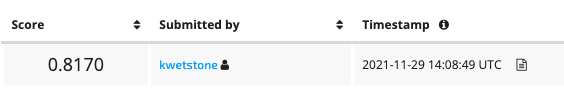

Our submission took about 20 minutes to execute. You can monitor progress during scoring with the Code Execution Status [tab](https://www.drivendata.org/competitions/83/submissions/code/). Finally, we see that we got an IOU of **0.817** - that's pretty good! It means that 81.7% of the area covered by either the ground truth labels or our predictions was shared between the two.

There is still plenty of room for improvement! Head over to the On Cloud N challenge [homepage](https://www.drivendata.org/competitions/83/cloud-cover/page/396/) to get started on your own model. We're excited to see what you create!